# Word Similarity using Word2Vec

In [4]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans 
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
plt.rcParams.update({'font.size': 16})

In [10]:
# import custom class
%run -i '../src/_text_analysis.py'

In [11]:
# instantiate the class
model = TextAnalytics()

## Load data

In [7]:
df = pd.read_csv('../data/sentence.csv')
print('Data size = {}'.format(df.shape))
df.head()

Data size = (111356, 3)


,sentence,company,sentiment
0,Excellent rewards and redeem easily when makin...,Walmart MASTERCARD,0.8481
1,I must note that I had also received 2 previou...,Walmart MASTERCARD,0.8225
2,I CALLED AND ASKED THEM WHY I WAS GETTING INTE...,Walmart MASTERCARD,0.8020
3,I have the Walmart Mastercard for over 2 years...,Walmart MASTERCARD,0.7845
4,After 6 weeks and a few major purchases I was ...,Walmart MASTERCARD,0.7783


## Sentiment categorization

In [6]:
df = df[df.sentiment != 0] # Remove neutral sentiment reviews
df['positivity'] = np.where(df.sentiment > 0,1,0) # Positivity score based on sentiments
(df['positivity'].value_counts()/len(df))*100

1    72.794788
0    27.205212
Name: positivity, dtype: float64

## Tokens and bigrams

In [16]:
df['tokens'] = df.sentence.apply(model.my_tokenizer) # Convert text to tokens
df['bigram_tokens'] = model.add_bigram(df.tokens) # Add bigrams
df.head()

,sentence,company,sentiment,positivity,tokens,bigram_tokens
0,Excellent rewards and redeem easily when makin...,Walmart MASTERCARD,0.8481,1,"[excellent, reward, redeem, easily, purchase, ...","[excellent, reward, redeem, easily, purchase, ..."
1,I must note that I had also received 2 previou...,Walmart MASTERCARD,0.8225,1,"[must, note, previous, letter, walmart, offeri...","[must, note, previous, letter, walmart, offeri..."
2,I CALLED AND ASKED THEM WHY I WAS GETTING INTE...,Walmart MASTERCARD,0.8020,1,"[interest, close, guy, charge, interest, reocc...","[interest, close, guy, charge, interest, reocc..."
3,I have the Walmart Mastercard for over 2 years...,Walmart MASTERCARD,0.7845,1,"[walmart, year, month, ago, duplicate, charge,...","[walmart, year, month_ago, duplicate, charge, ..."
4,After 6 weeks and a few major purchases I was ...,Walmart MASTERCARD,0.7783,1,"[week, major, purchase, close, limit, since, p...","[week, major, purchase, close, limit, since, p..."


##  Word2vec embeddings

In [17]:
token_list = df.bigram_tokens.to_list() # list of bigram tokens
model = model.word2vec_embedding(token_list) # Train word2vec

## Similar words in the vocabulary

In [24]:
model.wv.most_similar(positive=['fee'] , topn=5)

[('monthly', 0.9162456393241882),
 ('interest', 0.9133058190345764),
 ('late_fee', 0.9062798023223877),
 ('penalty', 0.895461916923523),
 ('waive', 0.8838083744049072)]

In [25]:
model.wv.most_similar(positive=['cash_back'] , topn=5)

[('cashback', 0.9889180064201355),
 ('category', 0.9829301238059998),
 ('gas', 0.96934974193573),
 ('mile', 0.9569682478904724),
 ('gas_grocery', 0.9465908408164978)]

In [26]:
model.wv.most_similar(positive=['point'] , topn=5)

[('mile', 0.9819282293319702),
 ('earn', 0.9710060954093933),
 ('cash', 0.9605771899223328),
 ('buy', 0.9596986174583435),
 ('redeem', 0.9584882259368896)]

## Feature matrix 

In [29]:
X = model.wv[model.wv.key_to_index] 
print('Data size = {}'.format(X.shape))

Data size = (11873, 300)


## TSNE dimensionality reduction

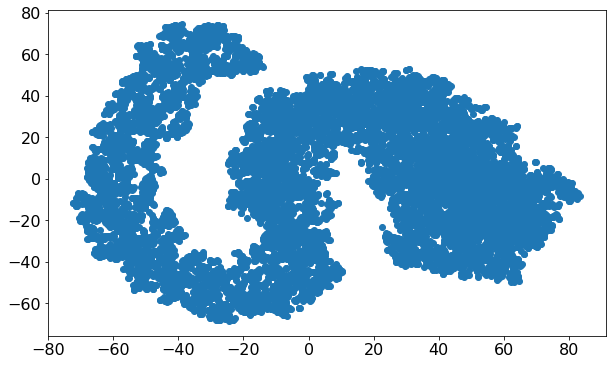

In [35]:
tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(X)

plt.figure(figsize=(10,6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1])
plt.show()

# Clustering

## 1. K-means

In [31]:
# Building and fitting the model 
kmeans_per_k = [KMeans(n_clusters=k, n_jobs=-1, random_state=0).fit(X)  for k in range(1,10)]
inertias = [model.inertia_ for model in kmeans_per_k]

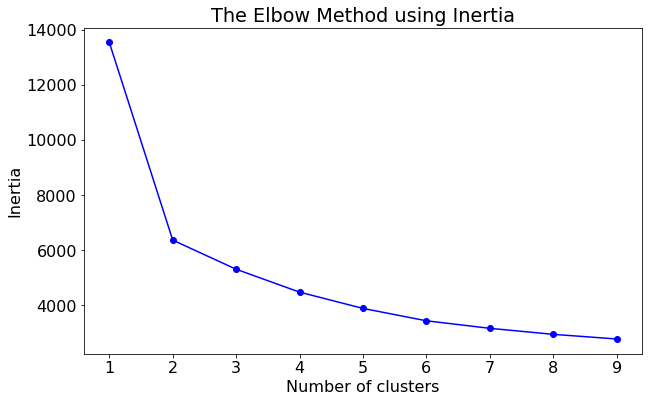

In [32]:
plt.figure(figsize = (10,6))
plt.plot(range(1,10), inertias, 'bo-') 
plt.xlabel('Number of clusters') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show()
#plt.xlim([0,10])

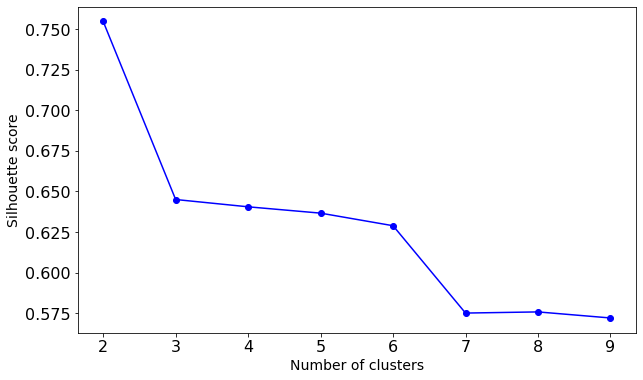

In [33]:
silhouette_scores = [silhouette_score(X, model.labels_) for model in kmeans_per_k[1:]]

plt.figure(figsize=(10, 6))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("Number of clusters", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.show()

## 2. Gaussian mixture

In [36]:
gms_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=42).fit(X)
             for k in range(1, 10)]

In [37]:
bics = [model.bic(X) for model in gms_per_k]
aics = [model.aic(X) for model in gms_per_k]

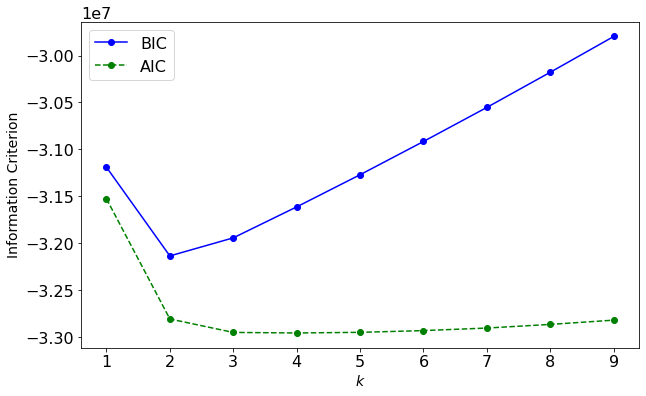

In [38]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 10), bics, "bo-", label="BIC")
plt.plot(range(1, 10), aics, "go--", label="AIC")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Information Criterion", fontsize=14)
plt.legend()
plt.show()
#plt.axis([1, 9.5, np.min(aics) - 50, np.max(aics) + 50])